In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

import keras 
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

Using TensorFlow backend.
/home/mandarsharma/cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mandarsharma/cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mandarsharma/cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mandarsharma/cpu/lib/python3.6/site-packages/tenso

In [2]:
data_dir = ''

In [3]:
edgelist = pd.read_csv(os.path.join(data_dir, "ppi.cites"), sep='\t', header=None, names=["source", "target"])
edgelist["label"] = "cites"  # set the edge type

In [ ]:
print(edgelist)

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

In [ ]:
import matplotlib.pyplot as plt
nx.draw(Gnx)
plt.show()

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(4132)]
column_names = feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "ppi.content"), sep='\t', header=None, names=column_names)

In [ ]:
print(node_data)

In [7]:
node_features = node_data[feature_names]

In [ ]:
print(node_features)

In [8]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [ ]:
print(G.info())

In [51]:
nodes = list(G.nodes())
number_of_walks = 1
length = 3

In [52]:
unsupervised_samples = UnsupervisedSampler(G, nodes=nodes, length=length, number_of_walks=number_of_walks)

In [53]:
batch_size = 50
epochs = 5
num_samples = [10, 5]

In [54]:
train_gen = GraphSAGELinkGenerator(G, batch_size, num_samples).flow(unsupervised_samples)

Running GraphSAGELinkGenerator with an estimated 496 batches generated on the fly per epoch.


In [55]:
layer_sizes = [50, 50]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.0, normalize="l2"
    )

In [56]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.build(flatten_output=False)

In [57]:
#sigmoid
prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
    )(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [58]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-1), #1e-3
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

In [59]:

history = model.fit_generator(
        train_gen,
        epochs=epochs,
        verbose=1,
        use_multiprocessing=True,
        workers=4,
        shuffle=True,
    )

Epoch 1/5
496/496 [==============================] - 222s 448ms/step - loss: 0.5957 - binary_accuracy: 0.7000
Epoch 2/5
496/496 [==============================] - 221s 446ms/step - loss: 0.5329 - binary_accuracy: 0.7918
Epoch 3/5
496/496 [==============================] - 222s 447ms/step - loss: 0.4348 - binary_accuracy: 0.9164
Epoch 4/5
496/496 [==============================] - 222s 447ms/step - loss: 0.3933 - binary_accuracy: 0.9533
Epoch 5/5
496/496 [==============================] - 221s 446ms/step - loss: 0.3741 - binary_accuracy: 0.9679


In [60]:
model.save('graphsage-5epoch.h5')

In [69]:
print(x_inp)
print(x_inp[0::2])

[<tf.Tensor 'input_31:0' shape=(?, 1, 4132) dtype=float32>, <tf.Tensor 'input_34:0' shape=(?, 1, 4132) dtype=float32>, <tf.Tensor 'input_32:0' shape=(?, 10, 4132) dtype=float32>, <tf.Tensor 'input_35:0' shape=(?, 10, 4132) dtype=float32>, <tf.Tensor 'input_33:0' shape=(?, 50, 4132) dtype=float32>, <tf.Tensor 'input_36:0' shape=(?, 50, 4132) dtype=float32>]
[<tf.Tensor 'input_31:0' shape=(?, 1, 4132) dtype=float32>, <tf.Tensor 'input_32:0' shape=(?, 10, 4132) dtype=float32>, <tf.Tensor 'input_33:0' shape=(?, 50, 4132) dtype=float32>]


In [70]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [71]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [72]:
node_ids = node_data.index
node_gen = GraphSAGENodeGenerator(G, batch_size, num_samples).flow(node_ids)

In [73]:
emb = embedding_model.predict_generator(node_gen, workers=4, verbose=1)
node_embeddings = emb[:,0,:]

83/83 [==============================] - 7s 87ms/step


In [74]:
node_subject = node_data["subject"].astype('category').cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed['label'] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] =  node_subject

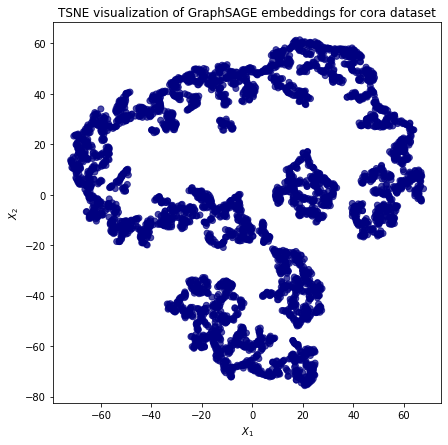

In [75]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for cora dataset'.format(transform.__name__))
plt.show()

In [76]:
X = node_embeddings

In [77]:
print(X.shape)

(4132, 50)


In [78]:
drug_embeddings = X[4125:, :]

In [79]:
print(drug_embeddings)

[[ 0.04670145 -0.05842644 -0.03429909  0.00609841 -0.06592118  0.05502038
  -0.03282627 -0.06173103 -0.04794145  0.02562666 -0.03862701 -0.01021498
   0.02628589 -0.0588074  -0.06709635 -0.03921317 -0.03697556 -0.03175336
   0.0020394  -0.0546196   0.04219823 -0.0352527   0.0551776   0.05216283
   0.00064208  0.2138061   0.22956808  0.16836204 -0.21695514 -0.16271266
  -0.19574536  0.20776595  0.210413    0.15866625  0.20117863 -0.18943195
   0.15160595  0.12428918  0.18771245 -0.18090898 -0.22420888  0.22617659
  -0.154436    0.20435771  0.23441836  0.15489191  0.21283147  0.22091568
  -0.20529889 -0.189255  ]
 [-0.20337671  0.18664055  0.14798868  0.03151816  0.21050027 -0.22887205
   0.18992868  0.21492204  0.14423817 -0.05152077  0.0755103   0.1162711
  -0.16739546  0.18973568  0.26650232  0.08847987  0.20147535  0.04305613
   0.04060147  0.23822093 -0.21307105  0.12459964 -0.24681345 -0.22785847
   0.02056557  0.11286838  0.12513174  0.08485235 -0.11377347 -0.08132929
  -0.1051446

In [80]:
node_ids = node_ids.values[4125:]

In [81]:
node_subject = node_data["subject"].astype('category').cat.codes

X = drug_embeddings
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed['label'] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] =  node_subject

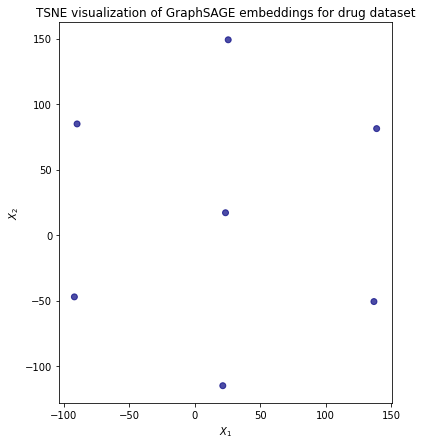

In [82]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings for drug dataset'.format(transform.__name__))
plt.show()

In [ ]:
print(drug_embeddings.shape)

In [ ]:
#DOT PRODUCT
edge_list = {}
for i in range(len(drug_embeddings)):
    for j in range(len(drug_embeddings)):
        edge_list[(i, j)] = np.dot(drug_embeddings[i], drug_embeddings[j])

In [ ]:
#HADAMARD PRODUCT
edge_list = {}
for i in range(len(drug_embeddings)):
    for j in range(len(drug_embeddings)):
        edge_list[(i, j)] = np.multiply(drug_embeddings[i], drug_embeddings[j]).tolist()

In [ ]:
print(edge_list)
# low_ = 1
# for k in edge_list.keys():
#     if edge_list[k] < low_:
#         low_ = edge_list[k]

In [ ]:
len(edge_list[(0,0)])

In [ ]:
import random

G = nx.gnp_random_graph(7,1)
for u,v,d in G.edges(data=True):
    d['weight'] = np.maximum(0, -1*low_ + round(edge_list[(u,v)], 2))

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='y', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.Reds, with_label=True)
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')
# nx.draw_networkx_edge_labels(G,pos, font_size=10)
plt.savefig('edges.png')

for u, v, d in G.edges(data=True):
    print(u,v, '  :  ', d)